In [17]:
import torch
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os
import torch.nn as nn

In [18]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device=None)}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"CUDNN: {torch.backends.cudnn.enabled}")

Device Name: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA: True
CUDNN: True


In [19]:
# Define ZFNet Architecture
class ZFNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(ZFNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [20]:
# Class to get Second Last Layer as Output
def get_second_last_layer_output(model, layer_name):
    def hook_fn(module, input, output):
        model._hidden_state = output  # Save output to a model attribute
    layer = dict([*model.named_modules()])[layer_name]  # Get layer by name
    layer.register_forward_hook(hook_fn)

In [21]:
# Load Models
resnet = models.resnet101(pretrained=True).to(device).eval()
zfnet = ZFNet(num_classes=1000).to(device).eval()
googlenet = models.googlenet(pretrained=True).to(device).eval()


/home/bzmysr/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bzmysr/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bzmysr/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.

In [22]:
# Register hooks on the second-last layers
get_second_last_layer_output(resnet, 'fc')  # For ResNet, 'fc' layer is the final fully connected layer
get_second_last_layer_output(zfnet, 'classifier.5')  # For ZFNet, the second-last layer in the classifier
get_second_last_layer_output(googlenet, 'fc')  # For GoogleNet, the 'fc' layer is the final


In [23]:
# Data Loading and Preprocessing
data_dir = 'dataset'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [24]:
# Feature Extraction Function
def extract_features_second_last(model, data_loader):
    features = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            model(images)  # Forward pass to trigger the hook
            features.append(model._hidden_state.cpu().numpy())  # Get second-last layer output
    features = np.concatenate(features)
    return features


# Extract features from the second-last layers of each model
resnet_features = extract_features_second_last(resnet, data_loader)
zfnet_features = extract_features_second_last(zfnet, data_loader)
googlenet_features = extract_features_second_last(googlenet, data_loader)

In [25]:
# Calculate Nearest Neighbors
def find_nearest_neighbors(features, n_neighbors=10):
    similarity_matrix = cosine_similarity(features)
    neighbors = np.argsort(similarity_matrix, axis=1)[:, -n_neighbors-1:-1]
    return neighbors

resnet_neighbors = find_nearest_neighbors(resnet_features)
zfnet_neighbors = find_nearest_neighbors(zfnet_features)
googlenet_neighbors = find_nearest_neighbors(googlenet_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

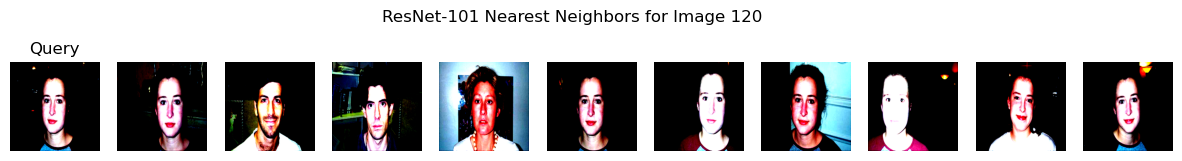

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

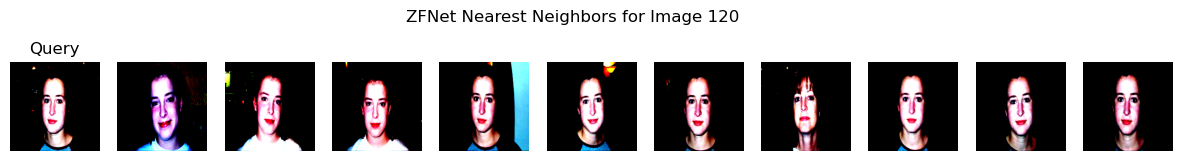

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

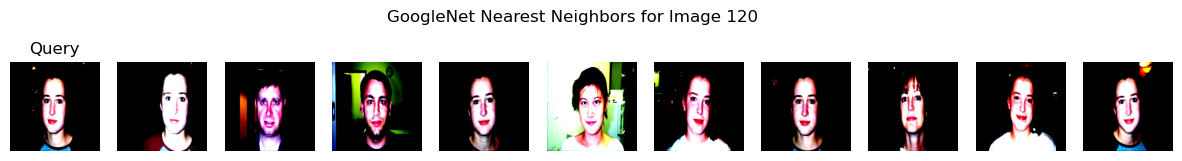

In [26]:
# Visualize Nearest Neighbors
def plot_neighbors(image_idx, neighbors, model_name):
    fig, axs = plt.subplots(1, 11, figsize=(15, 2))
    fig.suptitle(f"{model_name} Nearest Neighbors for Image {image_idx}")
    
    # Show query image
    query_image, _ = dataset[image_idx]
    axs[0].imshow(query_image.permute(1, 2, 0).numpy())
    axs[0].set_title("Query")
    axs[0].axis('off')
    
    # Show neighbors
    for i, neighbor_idx in enumerate(neighbors[image_idx]):
        neighbor_image, _ = dataset[neighbor_idx]
        axs[i + 1].imshow(neighbor_image.permute(1, 2, 0).numpy())
        axs[i + 1].axis('off')
    
    plt.show()

# Example: Display neighbors for a sample image index using each model
image_idx = 120  # Change this to visualize different images
plot_neighbors(image_idx, resnet_neighbors, "ResNet-101")
plot_neighbors(image_idx, zfnet_neighbors, "ZFNet")
plot_neighbors(image_idx, googlenet_neighbors, "GoogleNet")